This Jupyter notebook contains a tutorial that demonstrates how a recurrent reinforcement learning agent can target a financial risk position directly. The agent is aware of the various sources of profit and loss, including risk holding and execution cost. We will feed in some synthetic predictors and a synthetic target, training the model offline initially, then online as well. Finally, we will review the test set information ratio, which is a risk-adjusted return.
You need to have Python 3 installed and the following packages:
pandas, numpy, matplotlib, seaborn, joblib and tqdm.
Let's start by loading our required Python modules.

In [2]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm

plt.close('all')
sns.set()
eps = np.finfo(1.).eps
prec = 5
pd.options.display.float_format = ('{:.%df}' % prec).format
np.set_printoptions(precision=prec)
pd.set_option('display.precision', prec)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', 100)

Now let's generate predictors from a specified correlation matrix. Our target is a random linear combination of the predictors plus a drift term. We'll also generate an execution cost vector.

In [3]:
def generate_data(n=1000, p=10, drift=0.1, cost=1e-2):
    """
    Gram–Schmidt orthogonalisation of a random basis

    Args:
        n: number of observations
        p: number of predictors
        drift: a drift term for the target/response
        cost: the execution cost of trading the target as a price taker

    Returns: data: a dictionary containing the training and test data

    """
    C = np.array([[]])
    for j in range(100):
        A = np.random.randint(-10, 1000, (p, p)) / 1e3
        _, Q = np.linalg.eigh(A)
        d = np.sort(np.random.randn(p, ) ** 2)[::-1]
        D = np.diag(d)
        C = np.corrcoef(A.T @ D @ A)
        if np.all(np.linalg.eigvals(C) > 0):
            break

    # generate draws from a multivariate-normal with specified correlations
    rng = np.random.default_rng()
    _X_train = rng.multivariate_normal(np.zeros(p, ), C, (n,))
    b = np.random.uniform(size=(p,))
    b /= b.sum()
    _y_train = (_X_train * b).sum(axis=1) + np.random.uniform(high=drift, size=(n,))
    _cost_train = np.random.uniform(size=(n,)) * cost
    _X_test = rng.multivariate_normal(np.zeros(p, ), C, (n,))
    _y_test = (_X_test * b).sum(axis=1) + np.random.uniform(high=drift, size=(n,))
    _cost_test = np.random.uniform(size=(n,)) * cost
    _data = {'X_train': _X_train, 'y_train': _y_train, 'cost_train': _cost_train,
             'X_test': _X_test, 'y_test': _y_test, 'cost_test': _cost_test}
    return _data


Now we will create a class that represents our direct, recurrent reinforcement learning agent. We'll put comments throughout to aid in your understanding. We'll use stochastic gradient ascent with Nesterov momentum in order to train the model.

In [4]:
class DirectReinforcementLearner(object):
    def __init__(self, gamma=1e-5, nu=0.9, eta=1e-3, tau=0.99, min_epochs=10,
                 max_epochs=250, tol=1e-5, kappa=0.99, verbose=1, plot_me=True):
        """

        Args:
            gamma: quadratic utility function risk appetite.
            nu: Nesterov momentum gradient decay
            eta: gradient ascent learning rate.
            tau: utility function exponential decay factor.
            min_epochs: minimum number of gradient ascent training epochs.
            max_epochs: maximum number of gradient ascent training epochs.
            tol: stopping criteria for gradient ascent (weight norm).
            kappa: gradient ascent learning rate annealing weight.
            verbose: logging verbosity
            plot_me: show plots

        """
        self.gamma = gamma
        self.nu = nu
        self.eta = eta
        self.tau = tau
        self.min_epochs = min_epochs
        self.max_epochs = max_epochs
        self.tol = tol
        self.kappa = kappa
        self.verbose = verbose
        self.plot_me = plot_me

        self.w = np.array([])  # the position function weight vector that we must learn
        self.f = 0.  # current position
        self.mu = 0.  # expected net reward
        self.sigma2 = 1.  # variance of net reward
        self.u = self.mu - 0.5 * self.gamma * self.sigma2  # utility function
        self.ir = self.mu * np.sqrt(252 / (self.sigma2 + eps))  # information ratio

    @staticmethod
    def add_bias(X):
        n = len(X)
        if np.ndim(X) == 2 and n > 1:
            bias = np.ones(n, )
            X = np.column_stack([bias, X])
        else:
            X = np.append(1, X)
        return X

    @staticmethod
    def dtanh(x):
        """

        Args:
            x:

        Returns: the derivative of the tanh() with respect to x

        """
        return 1 - np.tanh(x) ** 2

    def fit(self, X, y, cost):
        """
        Offline fitting procedure for the direct reinforcement learner.

        Args:
            X: predictors.
            y: target returns.
            cost: target cost.

        Returns: None

        """
        X = self.add_bias(X)
        n, p = X.shape
        p += 1
        self.w = np.zeros(p, )
        epoch_str_len = len(str(self.max_epochs))
        u, w = [], []
        f_prev = 0
        for epoch in range(self.max_epochs):
            x = np.append(X[0, :], f_prev)
            w_prev = self.w.copy()
            df_dw, df_prev_dw_prev, v = np.zeros(p, ), np.zeros(p, ), np.zeros(p, )
            for i in range(n):
                # update utility function variables
                x_prev = x.copy()
                f_prev = self.f
                x = np.append(X[i, :], f_prev)
                self.f = np.tanh(self.w @ x)
                r = f_prev * y[i] - cost[i] * abs(f_prev - self.f)
                self.mu = self.tau * self.mu + (1 - self.tau) * r
                self.sigma2 = self.tau * self.sigma2 + (1 - self.tau) * (r - self.mu) ** 2
                self.u = self.mu - 0.5 * self.gamma * self.sigma2
                self.ir = self.mu / (self.sigma2 + eps) ** 0.5

                # compute the gradient of the utility function w.r.t. model params
                du_dr = (1 - self.eta) * (1 - self.gamma * (r - self.mu))
                dr_df = -cost[i] * np.sign(self.f - f_prev)
                df_prev2_dw_prev2 = df_prev_dw_prev
                df_prev_dw_prev = df_dw
                df_df_prev = self.w[-1] * self.dtanh(self.w @ x)
                df_dw = x * self.dtanh(self.w @ x) + df_df_prev * df_prev_dw_prev
                dr_dw = dr_df * df_dw
                dr_df_prev = y[i] + cost[i] * np.sign(self.f - f_prev)
                df_prev_df_prev2 = w_prev[-1] * self.dtanh(self.w @ x_prev)
                dr_dw_prev = (dr_df_prev *
                              (df_prev_dw_prev + df_prev_df_prev2 * df_prev2_dw_prev2))
                grad = du_dr * (dr_dw + dr_dw_prev)

                # weight update using Nesterov momentum (and learning rate annealing)
                w_prev = self.w.copy()
                v_prev = v
                eta = self.eta * self.kappa ** epoch
                v = self.nu * v - eta * grad
                self.w += self.nu * v_prev - (1 + self.nu) * v

            if self.verbose > 0:
                my_str = '\r%0*d/%d | utility: %.1e | mean: %.3f | var: %.3f |ir: %.3f'
                my_data = (epoch_str_len, epoch, self.max_epochs, self.u, self.mu,
                           self.sigma2, self.ir)
                sys.stderr.write(my_str % my_data)
                sys.stderr.flush()
            u.append(self.u)
            w.append(self.w.copy())
            dw = np.linalg.norm(w_prev - self.w)
            if epoch > self.min_epochs and dw / np.linalg.norm(self.w) < self.tol:
                break

        if self.plot_me is True:
            fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex='all')
            ax0.plot(u, label='utility')
            ax1.plot(w, label=['w%d' % j for j in range(p)])
            for ax in [ax0, ax1]:
                ax.legend(loc='best')
                ax.set_xlabel('training epoch')
            ax0.set_title('direct recurrent RL trading agent training')
            fig.tight_layout()

    def partial_fit_predict(self, X, y, cost):
        """
        Online fitting and prediction procedures for the direct reinforcement learner.

        Args:
            X: a matrix of predictors
            y: the target returns vector
            cost: execution cost vector

        Returns:
            df: a dataframe containing the agent's positions and rewards.
            gb: a profit and loss performance summary.

        """
        X = self.add_bias(X)
        n, p = X.shape
        p += 1
        position, reward = np.zeros(n, ), np.zeros(n, )
        f_prev = self.f
        x = np.append(X[0, :], f_prev)
        w_prev = self.w.copy()
        df_dw, df_prev_dw_prev, v = np.zeros(p, ), np.zeros(p, ), np.zeros(p, )
        weights = []
        for i in range(n):
            # update utility function variables
            x_prev = x.copy()
            f_prev = self.f
            x = np.append(X[i, :], f_prev)
            self.f = np.tanh(self.w @ x)
            r = f_prev * y[i] - cost[i] * abs(f_prev - self.f)
            reward[i] = r
            position[i] = f_prev
            self.mu = self.tau * self.mu + (1 - self.tau) * r
            self.sigma2 = self.tau * self.sigma2 + (1 - self.tau) * (r - self.mu) ** 2
            self.u = self.mu - 0.5 * self.gamma * self.sigma2
            self.ir = self.mu / (self.sigma2 + eps) ** 0.5

            # compute the gradient of the utility function w.r.t. model params
            du_dr = (1 - self.eta) * (1 - self.gamma * (r - self.mu))
            dr_df = -cost[i] * np.sign(self.f - f_prev)
            df_prev2_dw_prev2 = df_prev_dw_prev
            df_prev_dw_prev = df_dw
            df_df_prev = self.w[-1] * self.dtanh(self.w @ x)
            df_dw = x * self.dtanh(self.w @ x) + df_df_prev * df_prev_dw_prev
            dr_dw = dr_df * df_dw
            dr_df_prev = y[i] + cost[i] * np.sign(self.f - f_prev)
            df_prev_df_prev2 = w_prev[-1] * self.dtanh(self.w @ x_prev)
            dr_dw_prev = (dr_df_prev *
                          (df_prev_dw_prev + df_prev_df_prev2 * df_prev2_dw_prev2))
            grad = du_dr * (dr_dw + dr_dw_prev)

            # weight update using Nesterov momentum (and learning rate annealing)
            w_prev = self.w.copy()
            v_prev = v
            v = self.nu * v - self.eta * grad
            self.w += self.nu * v_prev - (1 + self.nu) * v
            weights.append(self.w.copy())
        df = pd.DataFrame({'position': position, 'reward': reward})
        gb = df.describe()
        gb.loc['sum', 'reward'] = reward.sum()
        gb.loc['ir', 'reward'] = gb.loc['mean', 'reward'] / gb.loc['std', 'reward']
        if self.verbose > 0:
            print('\ndirect recurrent RL trading test results:\n%s' % gb)
        if self.plot_me is True:
            fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(8, 6),
                                                sharex='all')
            ax0.plot(y.cumsum(), label='cumulative target return')
            ax1.stem(position, markerfmt='None', basefmt='C2-', linefmt='C2-',
                     label='position')
            ax2.plot(reward.cumsum(), label='cumulative agent return', color='tab:red')
            for ax in [ax0, ax1, ax2]:
                ax.legend(loc='best')
            ax0.set_title('direct recurrent RL trading agent test')
            fig.tight_layout()

        return df, gb

Now let's instantiate a DirectReinforcementLearner object and fit it offline initially. We will then continue to train it online during the test set and collect the resulting profit and loss. Just like with real trading, there's no guarantee that the model will achieve a profit after transaction costs are deducted. However, because we've added a positive tiny drift in the training and test data, it should be the case that the model learns to target a long position on average. We should also see that on average, our optimisation procedure will show an increasing utility function with each training epoch.

061/250 | utility: 9.7e-02 | mean: 0.097 | var: 0.462 |ir: 0.142


final training weights:
       w0      w1       w2      w3       w4       w5      w6      w7       w8      w9      w10     w11
0 1.96120 0.01823 -0.04819 0.02346 -0.00541 -0.01871 0.01417 0.02549 -0.00577 0.04488 -0.00604 1.30395

direct recurrent RL trading test results:
        position     reward
count 1000.00000 1000.00000
mean     0.99708    0.06555
std      0.00040    0.68716
min      0.99567   -2.48190
25%      0.99682   -0.39494
50%      0.99712    0.05524
75%      0.99737    0.51774
max      0.99798    2.06721
sum          NaN   65.55424
ir           NaN    0.09540

final test weights:
       w0      w1       w2      w3       w4       w5      w6      w7       w8      w9      w10     w11
0 1.96515 0.01848 -0.04689 0.02354 -0.00450 -0.01828 0.01465 0.02572 -0.00357 0.04502 -0.00496 1.30790


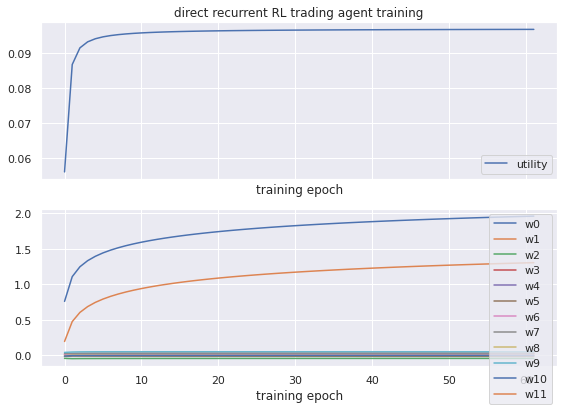

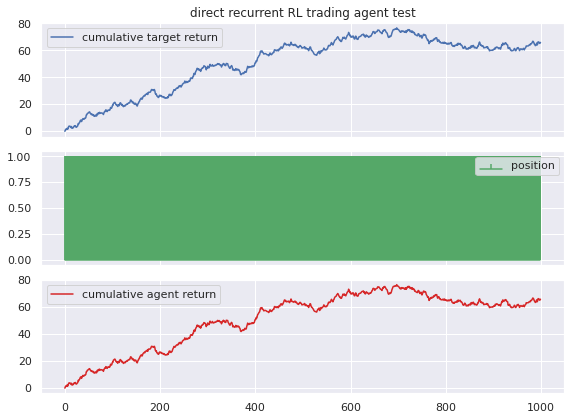

In [5]:
data = generate_data()
agent = DirectReinforcementLearner()
agent.fit(data['X_train'], data['y_train'], data['cost_train'])
p_ = data['X_train'].shape[1] + 2
w_ = pd.DataFrame(agent.w, index=['w%d' % j for j in range(p_)])
print('\nfinal training weights:\n%s' % w_.T)
df_, gb_ = agent.partial_fit_predict(data['X_test'], data['y_test'], data['cost_test'])
w_ = pd.DataFrame(agent.w, index=['w%d' % j for j in range(p_)])
print('\nfinal test weights:\n%s' % w_.T)
plt.show()

Let's perform a small scale Monte Carlo simulation where we run the previous experiment 250 times and look at the distribution of profits and losses achieved by our agent. We should see on average that it learns a long position as the target's returns are biased toward a marginal positive drift.

In [ ]:
def par_wrapper():
    plt.switch_backend('agg')
    _data = generate_data()
    _agent = DirectReinforcementLearner(max_epochs=50, verbose=0, plot_me=False)
    _agent.fit(_data['X_train'], _data['y_train'], _data['cost_train'])
    _df, _gb = _agent.partial_fit_predict(_data['X_test'], _data['y_test'], _data['cost_test'])
    return _gb


n_trials = 250
result = Parallel(n_jobs=-1)(delayed(par_wrapper)()
                             for _ in tqdm(range(n_trials), total=n_trials))
_reward, _position = [], []
for res in result:
    _reward.append(res['reward'])
    _position.append(res['position'])

_position = pd.concat(_position, axis=1).T.reset_index(drop=True)
_position.rename({'mean': 'average position'}, axis=1, inplace=True)
print('\nMonte Carlo simulation positions:\n%s' % _position.describe()['average position'])

_reward = pd.concat(_reward, axis=1).T.reset_index(drop=True)
_reward.rename({'mean': 'average return', 'std': 'risk', 'sum': 'total return'},
              axis=1, inplace=True)
gb_ = _reward.describe()[['average return', 'risk', 'total return', 'ir']]
print('\nMonte Carlo simulation returns:\n%s' % gb_)

g = sns.jointplot(data=_reward, x='risk', y='average return', kind='reg')
g.ax_joint.figure.tight_layout()
plt.show()

100%|██████████| 250/250 [01:17<00:00,  3.22it/s]
